## Modelamiento ARIMA 

# **Modelos ARIMA: Teoría y Validación**  

## **1. Teoría Básica de ARIMA**  

Los modelos **ARIMA** (*Autoregressive Integrated Moving Average*) se definen como:  

### **Componentes:**  

- **AR(p) - Autoregresivo (Orden $p$)**:  
  $
  X_t = c + \sum_{i=1}^p \phi_i X_{t-i} + \epsilon_t
  $  
  - $\phi_i$: Coeficientes del modelo.  
  - $p$: Número de retardos.  

- **I(d) - Integrado (Orden $d$)**:  
  - Diferenciación para lograr estacionariedad.  

- **MA(q) - Media Móvil (Orden $q$)**:  
  $
  X_t = \mu + \epsilon_t + \sum_{j=1}^q \theta_j \epsilon_{t-j}
  $
  - $\theta_j$: Coeficientes del error.  
  - $q$: Número de términos de error.  

### **Notación ARIMA(p,d,q):**  
- **$p$**: Orden AR.  
- **$d$**: Nivel de diferenciación.  
- **$q$**: Orden MA.  



## **2. Pruebas de Robustez**  

### **2.1. Estacionariedad**  
- **Prueba de Dickey-Fuller Aumentada (ADF):**  
  - Hipótesis nula ($H_0$): Raíz unitaria (no estacionaria).  
  - **Criterio:** $p$-valor $< 0.05$ → Serie estacionaria.  

### **2.2. Identificación de Órdenes (p,q)**  
- **ACF (Autocorrelación) y PACF (Autocorrelación Parcial):**  
  - Patrones ayudan a elegir $p$ y $q$.  
- **Criterios de Información:**  
  - Minimizar **AIC** o **BIC** para selección de modelo.  

### **2.3. Validación de Residuales**  
- **Prueba Ljung-Box:**  
  - $H_0$: Residuales son ruido blanco ($p > 0.05$).  
- **Normalidad:**  
  - Gráficos Q-Q o prueba Shapiro-Wilk.  

### **2.4. Estabilidad del Modelo**  
- **Raíces del polinomio AR/MA** deben estar dentro del círculo unitario.  



## **3. Proceso de Modelado**  

1. **Visualizar serie** (tendencias, estacionalidad).  
2. **Transformar a estacionaria** (diferenciación, log).  
3. **Identificar $p$, $q$** (ACF/PACF o `auto.arima`).  
4. **Ajustar modelo y validar residuos.**  
5. **Evaluar predicciones** (RMSE, MAPE).  



Cargamos librerías basicas :

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Importamos los datos : 

In [3]:
df = pd.read_excel("Series_tiempo.xlsx", parse_dates=['fecha'])
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y/%m')

print(df)

         fecha  importaciones  exportaciones
0   2000-01-01           4221           4568
1   2000-02-01           4157           4593
2   2000-03-01           4427           4857
3   2000-04-01           5268           5372
4   2000-05-01           3971           4537
..         ...            ...            ...
199 2016-08-01          10391           9500
200 2016-09-01           9849           8506
201 2016-10-01          10134           8588
202 2016-11-01          10893          11309
203 2016-12-01          13341          12956

[204 rows x 3 columns]


Graficamos la serie de tiempo:

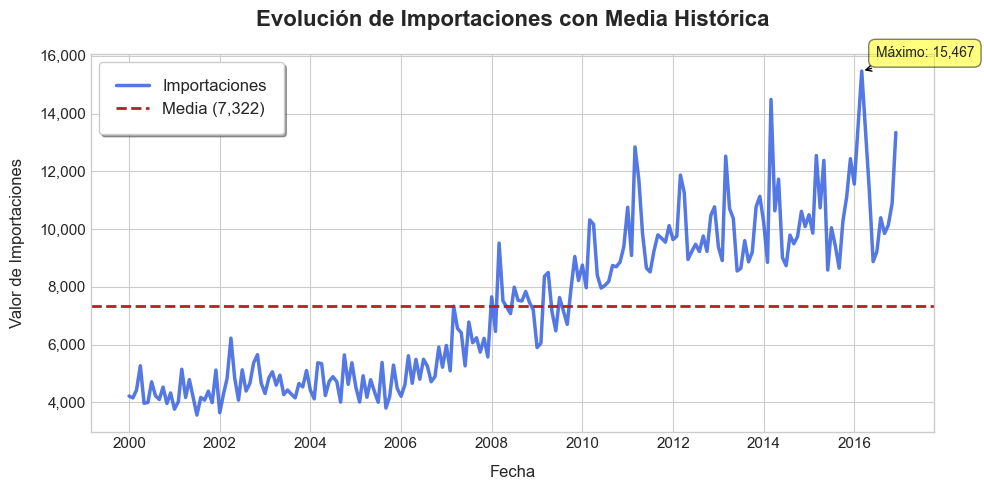

In [4]:

plt.style.use('seaborn-v0_8-whitegrid') 


plt.figure(figsize=(10, 5))
plt.plot(df['fecha'], 
         df['importaciones'], 
         label='Importaciones', 
         color='royalblue',
         linewidth=2.5,
         alpha=0.9)

media = df['importaciones'].mean()
plt.axhline(y=media, 
            color='firebrick', 
            linestyle='--', 
            linewidth=2,
            label=f'Media ({media:,.0f})')  


plt.title('Evolución de Importaciones con Media Histórica', 
          fontsize=16, 
          pad=20, 
          fontweight='bold')

plt.xlabel('Fecha', fontsize=12, labelpad=10)
plt.ylabel('Valor de Importaciones', fontsize=12, labelpad=10)


plt.legend(fontsize=12, 
           frameon=True, 
           shadow=True,
           borderpad=1)


plt.xticks(fontsize=11)
plt.yticks(fontsize=11)


max_val = df['importaciones'].max()
max_date = df.loc[df['importaciones'].idxmax(), 'fecha']
plt.annotate(f'Máximo: {max_val:,.0f}', 
             xy=(max_date, max_val),
             xytext=(10, 10), 
             textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->'))


plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))


plt.tight_layout()

plt.show()

#### Prueba de Dickey-Fuller para comprobar si la serie es estacionaria

In [5]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['importaciones']) 

# Extraer resultados
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# Imprimir resultados
print(f'Estadístico ADF: {adf_statistic:.4f}')
print(f'p-valor: {p_value:.4f}')
print('Valores críticos:')
for key, value in critical_values.items():
    print(f'   {key}: {value:.4f}')

# Interpretación
if p_value < 0.05:
    print("La serie es ESTACIONARIA (rechazamos H0)")
else:
    print("La serie NO es estacionaria (aceptamos H0)")

Estadístico ADF: 0.1421
p-valor: 0.9688
Valores críticos:
   1%: -3.4654
   5%: -2.8770
   10%: -2.5750
La serie NO es estacionaria (aceptamos H0)


#### Diferenciamos los datos y observamos su autocorrelación parcial

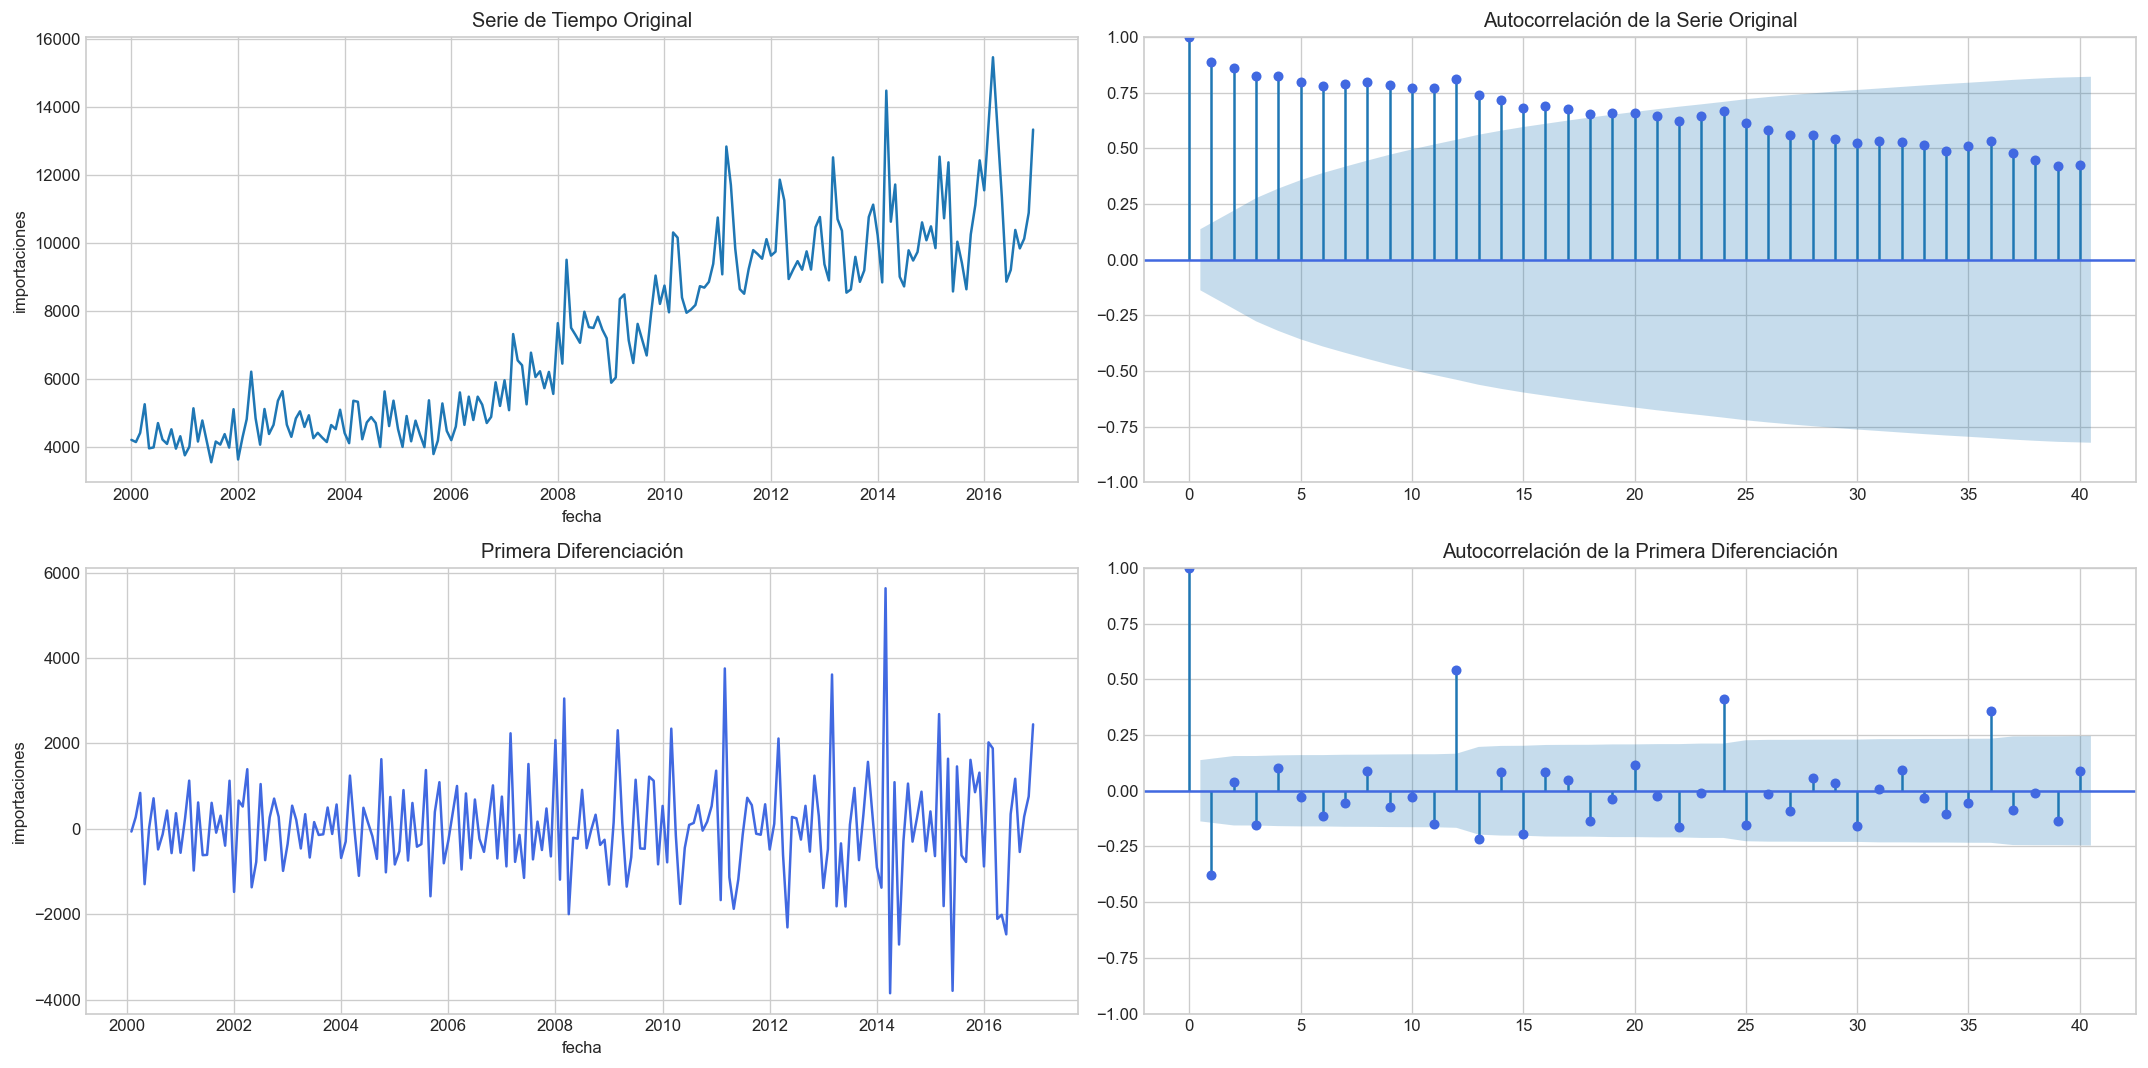

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

# Configuración del tamaño de los gráficos
plt.rcParams.update({'figure.figsize':(18,9), 'figure.dpi': 120})

# Crear la figura con 2 filas y 2 columnas
fig, ax = plt.subplots(nrows=2, ncols=2)

# Gráfico 1: Serie de tiempo original
sns.lineplot(x='fecha', y='importaciones', data=df, ax=ax[0, 0])
ax[0, 0].set_title("Serie de Tiempo Original")

# Gráfico 2: Autocorrelación de la serie original
plot_acf(df["importaciones"], lags=40, ax=ax[0, 1], color='royalblue')
ax[0, 1].set_title("Autocorrelación de la Serie Original")

# Gráfico 3: Primera diferenciación
sns.lineplot(x=df['fecha'][1:], y=df["importaciones"].diff()[1:], ax=ax[1, 0], color='royalblue')
ax[1, 0].set_title("Primera Diferenciación")

# Gráfico 4: Autocorrelación de la serie diferenciada
plot_acf(df["importaciones"].diff().dropna(), lags=40, ax=ax[1, 1], color='royalblue')
ax[1, 1].set_title("Autocorrelación de la Primera Diferenciación")

# Ajustar el layout para evitar superposiciones
plt.tight_layout()
plt.show()

#### Comprobamos si  los datos ya son estacionarios 

In [7]:
from statsmodels.tsa.stattools import adfuller

# Aplicar la prueba ADF a la serie diferenciada
adf_result_diff = adfuller(df["importaciones"].diff().dropna()) 

# Extraer resultados
adf_statistic_diff = adf_result_diff[0]
p_value_diff = adf_result_diff[1]
critical_values_diff = adf_result_diff[4]

# Mostrar resultados
print("**Prueba de Dickey-Fuller Aumentada (ADF) - Serie Diferenciada**")
print(f"Estadístico ADF: {adf_statistic_diff:.4f}")
print(f"p-valor: {p_value_diff:.8f}")
print("Valores críticos:")
for key, value in critical_values_diff.items():
    print(f"   {key}: {value:.4f}")

# Interpretación
if p_value_diff < 0.05:
    print(" Conclusión: La serie diferenciada es ESTACIONARIA (rechazamos H0 de raíz unitaria).")
else:
    print(" Conclusión: La serie diferenciada NO es estacionaria (se requiere más diferenciación).")

**Prueba de Dickey-Fuller Aumentada (ADF) - Serie Diferenciada**
Estadístico ADF: -4.3005
p-valor: 0.00044328
Valores críticos:
   1%: -3.4654
   5%: -2.8770
   10%: -2.5750
 Conclusión: La serie diferenciada es ESTACIONARIA (rechazamos H0 de raíz unitaria).


El término encontrado para el  modelo ARIMA es :
- El valor de $d=1$

### Econtrar el ordden del término del autoregresivo AR (p)

Inspreccionaremos el grafico de la autocorrelación parcial

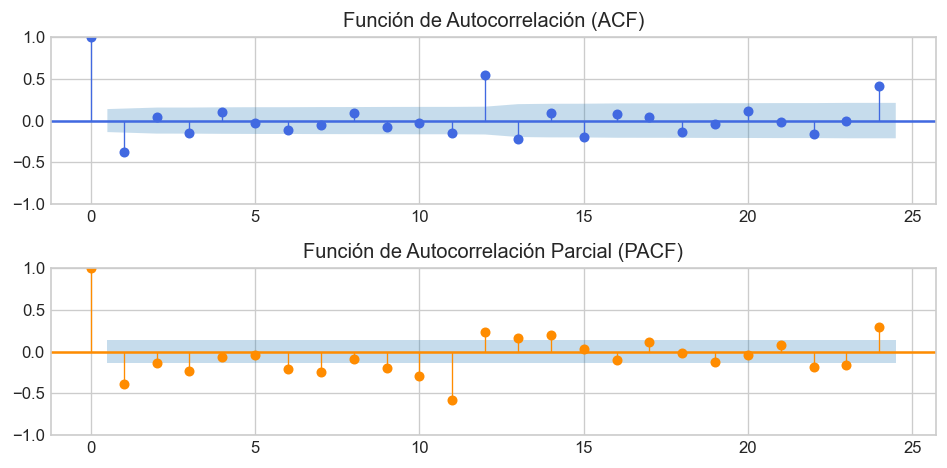

In [8]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.figsize': (8, 4), 'figure.dpi': 120})


fig, (ax1, ax2) = plt.subplots(2, 1)

# Autocorrelación (ACF)

plot_acf(df['importaciones'].diff().dropna(),  
         lags=24,                       # 24 lags 
         ax=ax1,
         color='royalblue',
         title='Función de Autocorrelación (ACF)',
         vlines_kwargs={'colors': 'royalblue', 'linewidth': 0.8},
         alpha=0.05)                    # significancia 95%

# Autocorrelación Parcial (PACF)
plot_pacf(df['importaciones'].diff().dropna(),
          lags=24,
          ax=ax2,
          color='darkorange',
          title='Función de Autocorrelación Parcial (PACF)',
          vlines_kwargs={'colors': 'darkorange', 'linewidth': 0.8},
          method='ols',                 # Método de estimación
          alpha=0.05)


plt.tight_layout()
plt.show()

Encontrar el termino MA con el grafico de autocorrelación simple

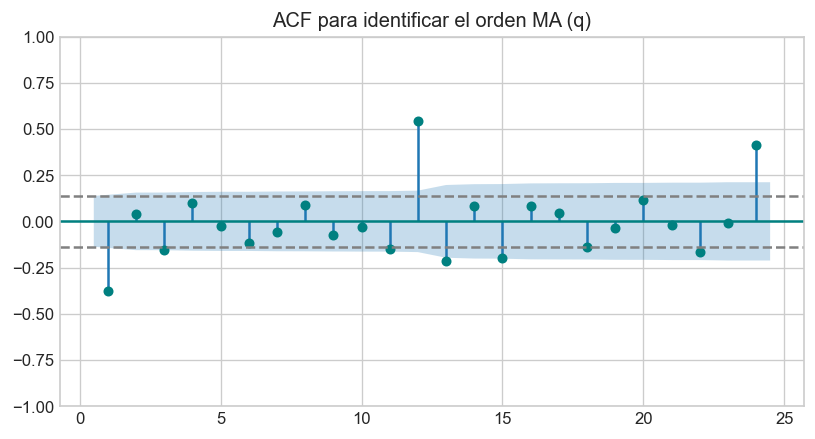

In [9]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Gráfico ACF para determinar q
plot_acf(df['importaciones'].diff().dropna(),  # Usar datos diferenciados si no son estacionarios
         lags=24,
         color='teal',
         title='ACF para identificar el orden MA (q)',
         zero=False)  # Elimina el lag 0 (siempre es 1)

plt.axhline(y=-1.96/np.sqrt(len(df)), color='gray', linestyle='--')  # Límite inferior
plt.axhline(y=1.96/np.sqrt(len(df)), color='gray', linestyle='--')  # Límite superior
plt.show()

In [10]:
from statsmodels.tsa.arima.model import ARIMA


# Ejemplo: Comparar q=1 vs q=2
model_q1 = ARIMA(df['importaciones'], order=(0,1,1))  # ARIMA(0,1,1)
model_q2 = ARIMA(df['importaciones'], order=(0,1,2))  # ARIMA(0,1,2)

results_q1 = model_q1.fit()
results_q2 = model_q2.fit()

print(f"AIC (q=1): {results_q1.aic:.2f}, AIC (q=2): {results_q2.aic:.2f}")

AIC (q=1): 3418.07, AIC (q=2): 3411.10


In [11]:
from statsmodels.tsa.arima.model import ARIMA

# 1. Ajustar el modelo ARIMA(1,1,1) a tus datos
model = ARIMA(df['importaciones'], order=(1, 1, 1))  # (p, d, q) = (1, 1, 1)
results = model.fit()

# 2. Mostrar el summary completo
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:          importaciones   No. Observations:                  204
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1700.768
Date:                Tue, 08 Jul 2025   AIC                           3407.537
Time:                        02:02:23   BIC                           3417.476
Sample:                             0   HQIC                          3411.558
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3110      0.080      3.872      0.000       0.154       0.468
ma.L1         -0.8568      0.043    -20.052      0.000      -0.941      -0.773
sigma2      1.099e+06   6.59e+04     16.670      0.0

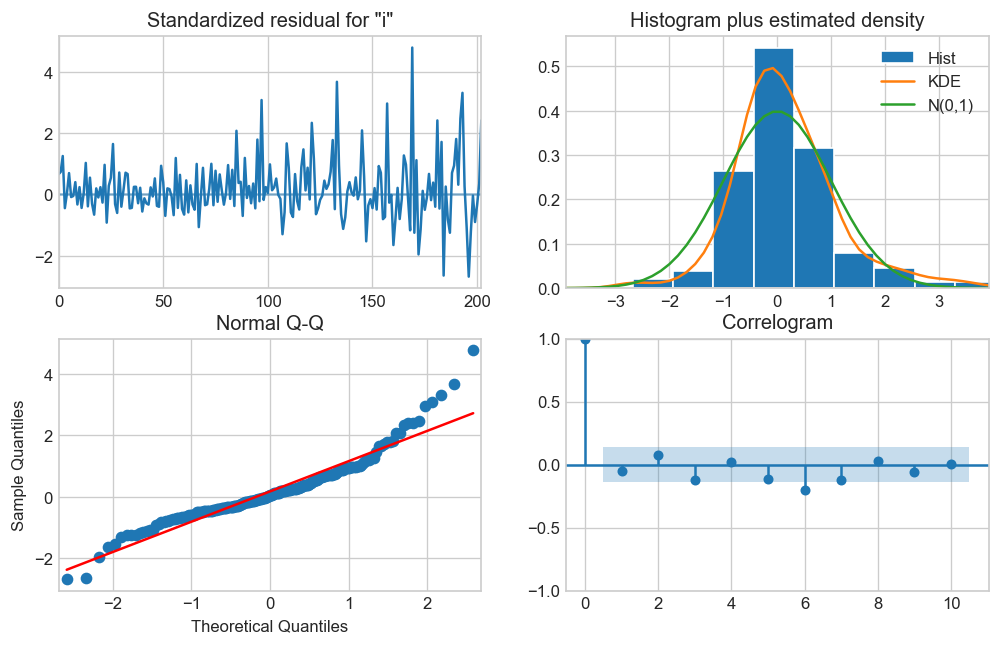

In [12]:
results.plot_diagnostics(figsize=(10, 6))
plt.show()

In [13]:
# Predicciones para los próximos 5 periodos
forecast = results.get_forecast(steps=5)
print(forecast.predicted_mean)

204    11936.235328
205    11499.312544
206    11363.416815
207    11321.149280
208    11308.002844
Name: predicted_mean, dtype: float64


c:\Users\Cesar_2borgbt\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Cesar_2borgbt\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Cesar_2borgbt\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


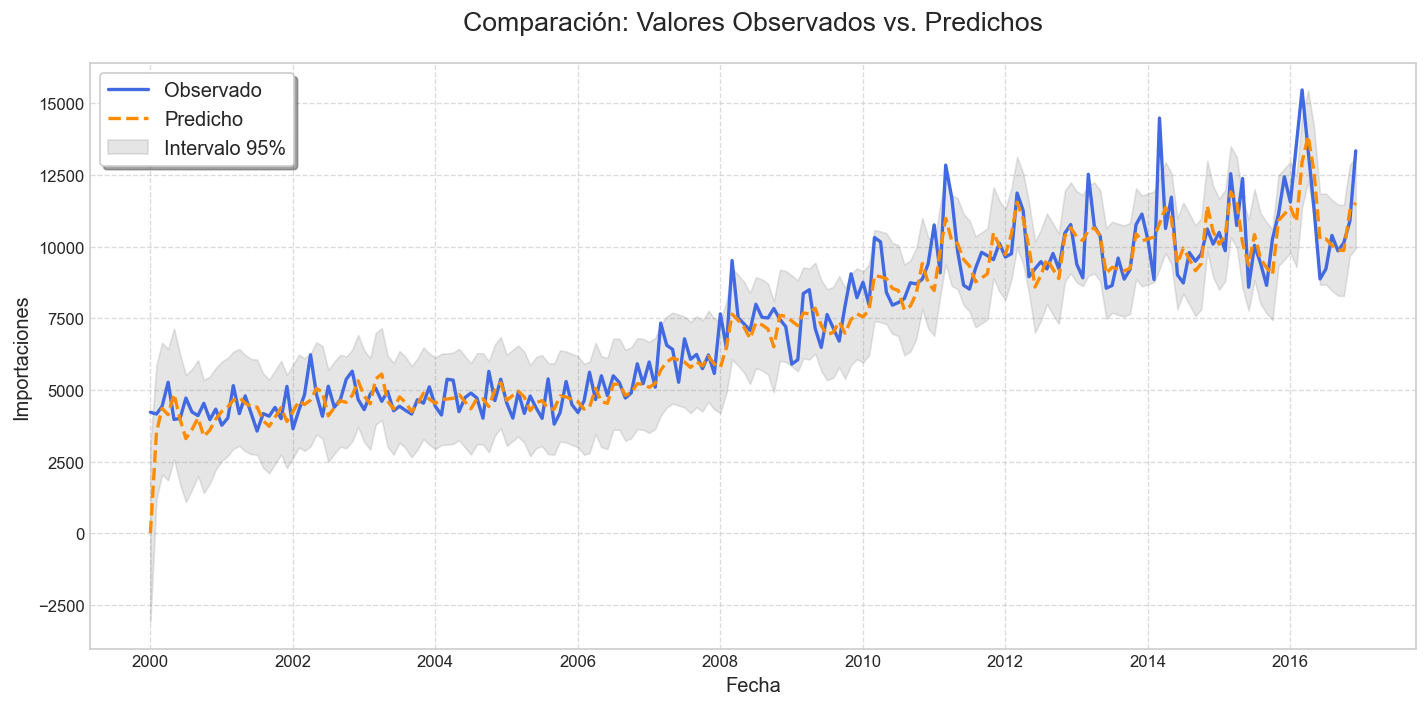

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# 1. Ajustar el modelo ARIMA (ejemplo: ARIMA(1,1,1))
model = ARIMA(df['importaciones'], order=(1, 1, 1))
results = model.fit()

# 2. Obtener predicciones "in-sample" (ajuste dentro de la muestra)
predictions = results.get_prediction(start=0, dynamic=False)  # Predicciones estáticas
predicted_means = predictions.predicted_mean
conf_int = predictions.conf_int()  # Intervalos de confianza

# 3. Crear DataFrame comparativo
comparison = pd.DataFrame({
    'Observado': df['importaciones'],
    'Predicho': predicted_means,
    'Fecha': df['fecha']
})

# 4. Graficar
plt.figure(figsize=(12, 6))
plt.plot(comparison['Fecha'], comparison['Observado'], 
         label='Observado', color='royalblue', linewidth=2)
plt.plot(comparison['Fecha'], comparison['Predicho'], 
         label='Predicho', color='darkorange', linestyle='--', linewidth=2)
plt.fill_between(comparison['Fecha'], 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='gray', alpha=0.2, label='Intervalo 95%')

# Personalización
plt.title('Comparación: Valores Observados vs. Predichos', fontsize=16, pad=20)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Importaciones', fontsize=12)
plt.legend(fontsize=12, frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\Cesar_2borgbt\AppData\Local\Temp\ipykernel_34308\1850462865.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]  # 'M' para frecuencia mensual


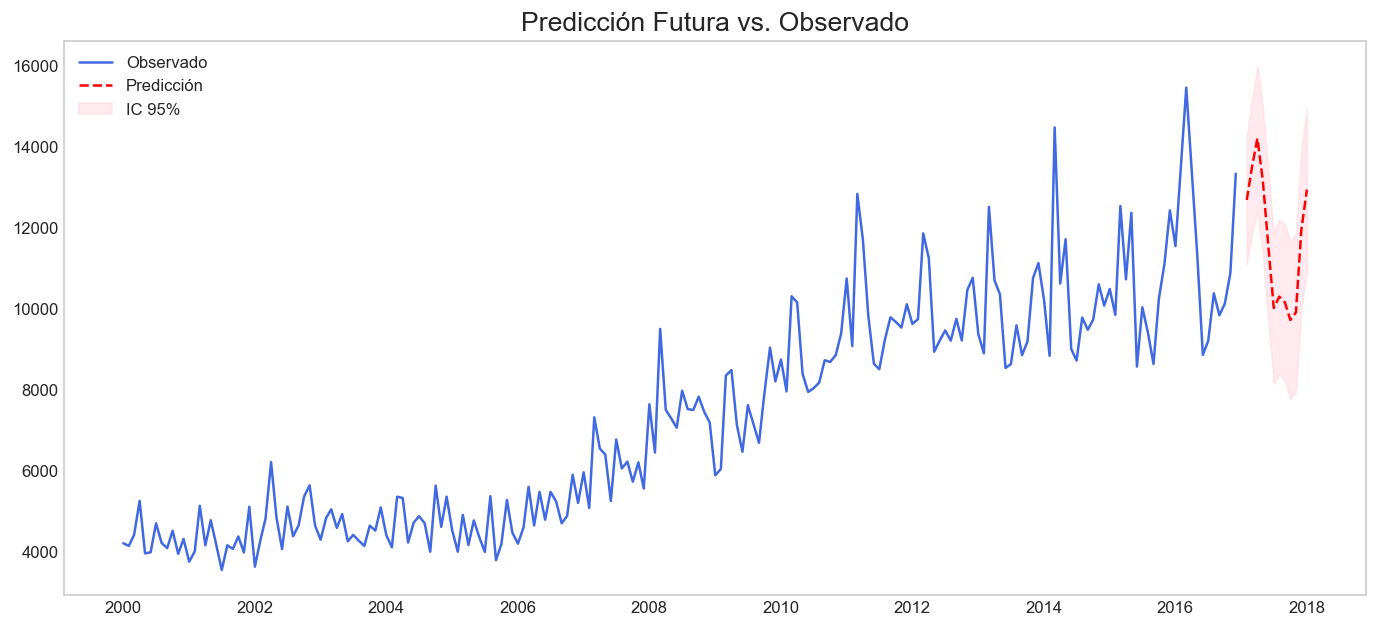

In [15]:
# Predicciones para 12 periodos futuros
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Crear rango de fechas futuras
last_date = df['fecha'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]  # 'M' para frecuencia mensual

# Graficar observados + futuro
plt.figure(figsize=(14, 6))
plt.plot(df['fecha'], df['importaciones'], label='Observado', color='royalblue')
plt.plot(future_dates, forecast_mean, label='Predicción', color='red', linestyle='--')
plt.fill_between(future_dates, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3, label='IC 95%')
plt.title('Predicción Futura vs. Observado', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(df['importaciones'], predicted_means)
rmse = np.sqrt(mse)  # Raíz cuadrada del MSE
print(f'RMSE: {rmse:.2f}')

RMSE: 885.92


## Autorima para mejorar el rendimiento 

In [18]:
import itertools
import warnings
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

def auto_arima_custom_diff(series, p_range=10, q_range=5, d=1, trace=True):
    """
    Versión optimizada para series diferenciadas (d=1) sin dependencia de tqdm.
    
    Args:
        series: Serie temporal (Pandas Series).
        p_range: Máximo orden AR (basado en PACF con 9 rezagos).
        q_range: Máximo orden MA (basado en ACF con 5 rezagos).
        d: Orden de diferenciación (fijo en 1).
        trace: Muestra progreso.
        
    Returns:
        Mejor modelo ARIMA y DataFrame con resultados.
    """
    warnings.filterwarnings("ignore")
    
    p_range = range(0, p_range + 1)
    q_range = range(0, q_range + 1)
    pdq_combinations = list(itertools.product(p_range, [d], q_range))
    
    results = []
    best_aic = float("inf")
    best_model = None
    
    if trace:
        print(f"Evaluando {len(pdq_combinations)} combinaciones ARIMA...")
    
    for i, order in enumerate(pdq_combinations, 1):
        p, d, q = order
        try:
            model = ARIMA(series, order=order)
            model_fit = model.fit()
            aic = model_fit.aic
            results.append({'order': order, 'aic': aic})
            
            if aic < best_aic:
                best_aic = aic
                best_model = model_fit
                best_order = order
            
            if trace:
                print(f"Progreso: {i}/{len(pdq_combinations)} | ARIMA{order}: AIC={aic:.2f}")
        except:
            if trace:
                print(f"Progreso: {i}/{len(pdq_combinations)} | ARIMA{order}: Error (se omite)")
            continue
    
    results_df = pd.DataFrame(results).sort_values(by='aic').reset_index(drop=True)
    
    print("\n🔎 Resultados:")
    print(f"Mejor modelo: ARIMA{best_order} | AIC={best_aic:.2f}")
    print("Top 3 modelos:")
    print(results_df.head(3))
    
    return best_model, results_df

# Uso con tus datos
best_model, results_df = auto_arima_custom_diff(
    df['importaciones'], 
    p_range=9,  # Según tu PACF
    q_range=5,  # Según tu ACF
    d=1,
    trace=True
)

Evaluando 60 combinaciones ARIMA...
Progreso: 1/60 | ARIMA(0, 1, 0): AIC=3459.35
Progreso: 2/60 | ARIMA(0, 1, 1): AIC=3418.07
Progreso: 3/60 | ARIMA(0, 1, 2): AIC=3411.10
Progreso: 4/60 | ARIMA(0, 1, 3): AIC=3406.60
Progreso: 5/60 | ARIMA(0, 1, 4): AIC=3407.66
Progreso: 6/60 | ARIMA(0, 1, 5): AIC=3409.54
Progreso: 7/60 | ARIMA(1, 1, 0): AIC=3430.55
Progreso: 8/60 | ARIMA(1, 1, 1): AIC=3407.54
Progreso: 9/60 | ARIMA(1, 1, 2): AIC=3408.87
Progreso: 10/60 | ARIMA(1, 1, 3): AIC=3407.89
Progreso: 11/60 | ARIMA(1, 1, 4): AIC=3409.52
Progreso: 12/60 | ARIMA(1, 1, 5): AIC=3411.16
Progreso: 13/60 | ARIMA(2, 1, 0): AIC=3429.45
Progreso: 14/60 | ARIMA(2, 1, 1): AIC=3408.97
Progreso: 15/60 | ARIMA(2, 1, 2): AIC=3405.22
Progreso: 16/60 | ARIMA(2, 1, 3): AIC=3409.88
Progreso: 17/60 | ARIMA(2, 1, 4): AIC=3400.55
Progreso: 18/60 | ARIMA(2, 1, 5): AIC=3400.92
Progreso: 19/60 | ARIMA(3, 1, 0): AIC=3422.09
Progreso: 20/60 | ARIMA(3, 1, 1): AIC=3408.74
Progreso: 21/60 | ARIMA(3, 1, 2): AIC=3407.16
Progres

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# 1. Ajustar el modelo ARIMA (ejemplo: ARIMA(1,1,1))
model = ARIMA(df['importaciones'], order=(9, 1, 5))  # Reemplaza con tus (p,d,q)
results = model.fit()

# 2. Definir el horizonte de predicción (10 años = 120 meses si es mensual)
forecast_steps = 12  # 12 meses * 10 años
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# 3. Crear rango de fechas futuras (asumiendo frecuencia mensual)
last_date = df['fecha'].iloc[-1]
future_dates = pd.date_range(
    start=last_date, 
    periods=forecast_steps + 1,  # +1 para evitar solapamiento
    freq='M'  # 'M' = mensual. Usa 'Y' si es anual, 'D' si es diario, etc.
)[1:]  # Elimina la primera fecha (duplicada)

# 4. Graficar observados + predicciones futuras
plt.figure(figsize=(14, 6))
plt.plot(df['fecha'], df['importaciones'], label='Observado', color='royalblue', linewidth=2)
plt.plot(future_dates, forecast_mean, label='Predicción (1 año)', color='red', linestyle='--')
plt.fill_between(
    future_dates, 
    forecast_conf_int.iloc[:, 0], 
    forecast_conf_int.iloc[:, 1], 
    color='pink', alpha=0.3, label='Intervalo 95%'
)

# Personalización del gráfico
plt.title('Predicción de Importaciones para 1 Año', fontsize=16, pad=20)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Importaciones', fontsize=12)
plt.legend(fontsize=10, frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()